#### Clickbait Detection on Headline's text using Deberta and Electra pre-trained Models and their Tokenizers

In [1]:
from sklearn.metrics import f1_score, balanced_accuracy_score, mean_squared_error, confusion_matrix, recall_score, precision_score, accuracy_score, log_loss
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments, BertweetTokenizer, BertConfig
from torch.utils.data import Dataset, DataLoader
import torch

# import nltk
# nltk.download('punkt')
# from nltk.tokenize import sent_tokenize
# from nltk.corpus import stopwords
# import re

import pandas as pd
import numpy as np
import random
import json
import os
import re
import gc

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = './Webis17HeadlineClsData/'  # Webis17HeadlineClsData or Webis17HeadlineArticleClsData
root = "./"

In [3]:
df_train = pd.read_csv(path+'train.csv')
df_validation = pd.read_csv(path+'validation.csv')
df_test = pd.read_csv(path+'test.csv')

In [4]:
df_train.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [5]:
len(df_train), len(df_validation), len(df_test)

(19538, 2459, 18979)

In [6]:
# doing the following data processing resulted into poor model performance 

# nltk.download('stopwords')

# stop_words = set(stopwords.words('english'))
# #https://catriscode.com/2021/05/01/tweets-cleaning-with-python/
# def clean_data(tweet):
#     if type(tweet) == np.float:
#         return ""
#     temp = tweet.lower()
#     temp = re.sub("'", "", temp) # to avoid removing contractions in english
#     temp = re.sub("@[A-Za-z0-9_]+","", temp)
#     temp = re.sub("#[A-Za-z0-9_]+","", temp)
#     temp = re.sub(r'http\S+', '', temp)
#     temp = re.sub('[()!?]', ' ', temp)
#     temp = re.sub('\[.*?\]',' ', temp)
#     temp = re.sub("[^a-z0-9]"," ", temp)
#     temp = temp.split()
#     temp = [w for w in temp if not w in stop_words]
#     temp = " ".join(word for word in temp)
#     return temp

# #https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
# def deEmojify(text):
# #     print(text)
#     regrex_pattern = re.compile(pattern = "["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags = re.UNICODE)
#     return regrex_pattern.sub(r'',text)

In [7]:
# df_train['postText'] = df_train['postText'].astype(str)
# df_validation['postText'] = df_validation['postText'].astype(str)
# df_test['postText'] = df_test['postText'].astype(str)

In [8]:
# df_train['postText'] = df_train['postText'].apply(deEmojify)
# df_train['postText'] = df_train['postText'].apply(clean_data)

# df_validation['postText'] = df_validation['postText'].apply(deEmojify)
# df_validation['postText'] = df_validation['postText'].apply(clean_data)

# df_test['postText'] = df_test['postText'].apply(deEmojify)
# df_test['postText'] = df_test['postText'].apply(clean_data)

In [9]:
def normalize_sentence(sentence, replace_url=False, replace_usr=False):
    if not replace_url and not replace_usr:
        #print(replace_url,replace_usr)
        return sentence
    new_sentence = []
    for word in sentence.split(" "):
        # print(word)
        # @mentions, @users
        if (word.startswith("@") or word.startswith('"@')) and replace_usr:
            new_sentence.append('@user')
        # URL: https, http
        elif (word.startswith("http:") or word.startswith("https:")) and replace_url:
            new_sentence.append('internet_site')
        else:
            new_sentence.append(word)
    # remove extra " "
    new_sentence = re.sub(' +', ' ', " ".join(new_sentence))
    return new_sentence.strip()

In [10]:
def get_dataset(df_train,df_dev,df_test,root,replace_url=False,replace_usr=False):
    trainDataset = df_train[['postText', 'truthClass']].copy()
    trainDataset['x'] = trainDataset.postText.astype(str).apply(lambda a: normalize_sentence(a,replace_url,replace_usr))
    trainDataset['y'] = trainDataset.truthClass.str.strip()
    print('Total amount of train',len(trainDataset.index))

    validationDataset = df_dev[['postText', 'truthClass']].copy()
    validationDataset['x'] = validationDataset.postText.astype(str).apply(lambda a: normalize_sentence(a,replace_url,replace_usr))
    validationDataset['y'] = validationDataset.truthClass.str.strip()
    print('Total amount of validation',len(validationDataset.index))

    testDataset = df_test[['postText', 'truthClass']].copy()
    testDataset['x'] = testDataset.postText.astype(str).apply(lambda a: normalize_sentence(a,replace_url,replace_usr))
    testDataset['y'] = testDataset.truthClass.str.strip()
    print('Total amount of test',len(testDataset.index))

    return trainDataset, validationDataset, testDataset

trainDataset, validationDataset, testDataset = get_dataset(df_train, df_validation, df_test, ".", True, True)

labels = list(set(trainDataset.truthClass.tolist()))
labels.sort(key=lambda item: (-len(item), item), reverse=True)
nLabels = len(labels)
print('Labels:', labels)

trainDataset = trainDataset.drop(['postText', 'truthClass'], axis=1)
validationDataset = validationDataset.drop(['postText', 'truthClass'], axis=1)
testDataset = testDataset.drop(['postText', 'truthClass'], axis=1)

Total amount of train 19538
Total amount of validation 2459
Total amount of test 18979
Labels: ['clickbait', 'no-clickbait']


In [11]:
print(testDataset.head())

                                                   x             y
0  Johnny Manziel on Browns' No. 1 pick Myles Gar...  no-clickbait
1  Fabio: California Is a 'Mess' Because of Liber...  no-clickbait
2            "He's been huge for us this year, man."     clickbait
3  New Bears quarterback Mitchell Trubisky was gr...  no-clickbait
4  It's not enough to let employees work flexible...  no-clickbait


In [12]:
class Trainer(Trainer):
    def evaluate(self, eval_dataset= None, ignore_keys=None):
        outputMetrics = super().evaluate(eval_dataset, ignore_keys)
#         print('outputMetrics: ', outputMetrics)
        return outputMetrics

In [13]:
class gn_dataset(Dataset):
    def __init__(self,data,labels,tokenizer):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer

    def processText(self, text):
        tokenized = self.tokenizer(text, truncation=True)

        return tokenized

    def __len__(self):
        return len(self.data.index)

    def __getitem__(self,i):
        row = self.data.iloc[i]
        x = self.processText(row['x']).data

        try:
            y = self.labels.index(row['y'])
        except:
            y = len(self.labels) - 1 

        x['labels'] = y
        return x

    def randomItem(self):
        return self.__getitem__(random.randint(0,self.__len__()))


In [14]:
all_computeMetrics = []
test_metrics = []

In [15]:
class Model:
    def __init__(self,modelPath = '',nLabels = 3, labels=None):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # put cpu for more extensive error desc...
        print('device: ', self.device)
        self.maxLength = 128  # max len we have is 124 for postext
        self.nLabels = nLabels
        self.loadModel(modelPath) 
        print('** Model: ', self.loadModel)

        self.labels = labels

    def model_init(self, dropout = 0.1):
        config = AutoConfig.from_pretrained(
                    self.MODEL_PATH,
                    num_labels=self.nLabels,
                    return_dict = True,
                    hidden_dropout_prob = dropout
                )
        print('configconfig', config)
        return AutoModelForSequenceClassification.from_pretrained(self.MODEL_PATH,config=config).to(self.device)

    def softmax_stable(self,x):
        z = x - np.max(x, axis=1)[:, np.newaxis]
        softmax = np.exp(z) / np.sum(np.exp(z), axis=1)[:, np.newaxis]
        return softmax

    def computeMetrics(self,evalPrediction):
        yTrue = evalPrediction.label_ids
        pp = self.softmax_stable(evalPrediction.predictions)
        # take the 1st col
        first_col = pp[:, 1:]
        # apply new thresh on this col
        yPred = (first_col > 0.25).astype(int).flatten()
    
#     this is default 0.5 thresh
#         yPredd = evalPrediction.predictions.argmax(1)

        metrics = {}
        
        metrics['val accuracy'] = accuracy_score(yTrue, yPred)
        metrics['f1'] = f1_score(yTrue, yPred)

        recall = recall_score(yTrue, yPred) 
        precision = precision_score(yTrue, yPred)
        metrics['precision'] = precision
        metrics['recall'] = recall
        print(yTrue)
        print('@@', yPred, first_col)
        precision, recall, thresholds = precision_recall_curve(yTrue, first_col)
        fig, ax = plt.subplots()
        ax.plot(recall, precision, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
                
        all_computeMetrics.append(metrics)
        
        return metrics

    def loadModel(self,modelPath):
        self.MODEL_PATH = modelPath
        self.MODEL = self.model_init()
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH,model_max_length = self.maxLength, use_fast=True)
        
    def saveModel(self,saveDir):
        print('saving model at: ', saveDir)
        self.MODEL.save_pretrained(saveDir)
        self.TOKENIZER.save_pretrained(saveDir)

    def train_loop(self,saveDir,checkpointDir,trainingData,validationData,testData,labels):
        trainDataset = gn_dataset(trainingData,labels,self.TOKENIZER)
        validationDataset = gn_dataset(validationData,labels,self.TOKENIZER)
        testDataset = gn_dataset(testData,labels,self.TOKENIZER)
        checkpoints = {}

        # TRAIN FUNCTION
        runName = experiment + str(len(checkpoints))
        print('checkpointDir: ', checkpointDir)

        args = TrainingArguments(
                                output_dir=checkpointDir,
                                save_strategy='no',
                                do_train=True, # DEFAULT: False
                                do_eval=True, # DEFAULT: False
                                do_predict=True, # DEFAULT: False
#                                 save_steps = 1200, # DEFAULT: 500
#                                 eval_steps = 1, #200, # DEFAULT: 500
                                evaluation_strategy = 'epoch', # DEFAULT: "no"
                                logging_first_step = True, # DEFAULT: False
                                dataloader_num_workers = 6, # 6, DEFAULT: 0
                                learning_rate = 2e-5,
                                num_train_epochs = 3,
                                per_device_train_batch_size = 8,
                                per_device_eval_batch_size = 8, #16,
                                weight_decay = 0.05 ,
                                warmup_steps = 0, # DEFAULT: 0
                                logging_dir=checkpointDir+"/logs",
                                metric_for_best_model = 'f1_binary', # DEFAULT: None
                                greater_is_better = True, # DEFAULT: None
                                
        )
        model = self.model_init(dropout=0.3)

        trainer = Trainer(
                    model,
                    args = args,
                    train_dataset = trainDataset,#train
                    tokenizer = self.TOKENIZER,
                    eval_dataset = validationDataset,#dev
                    compute_metrics = self.computeMetrics,
                )

        trainer.train()

        cp = checkpointDir + '/CheckPointModel_'+ runName

        checkpoints[cp] = trainer.evaluate(testDataset) # on test set
        print('on test set:', checkpoints[cp]) 
        test_metrics.append(checkpoints[cp])
#         trainer.predict(testDataset)
#         trainer.save_model(cp)
        
    def predict(self,text):
        dataset = gn_dataset(None,None,self.TOKENIZER)
        batchEncoding = dataset.processText(text).to(self.device)

        self.MODEL.eval()
        out = self.MODEL(batchEncoding.input_ids,attention_mask = batchEncoding.attention_mask,token_type_ids = batchEncoding.token_type_ids,return_dict = True)

        return out.logits.argmax().item()

In [16]:
def train(name,root,nLabels,labels,experiment,trainDataset,validationDataset,testDataset): 
    print('name experiment: ', name, experiment)
    model = Model(name,nLabels,labels)
    print('model model: ', model)
    analysis = model.train_loop(root+"SavedModel/"+experiment,root+name.split('/')[-1]+"TrainingCheckpoints",trainDataset,validationDataset,testDataset,labels)
    return True

name experiment:  google/electra-base-discriminator electra_clickbait
device:  cuda
configconfig ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

** Model:  <bound method Model.loadModel of <__main__.Model object at 0x7fabc28506d8>>
model model:  <__main__.Model object at 0x7fabc28506d8>
checkpointDir:  ./electra-base-discriminatorTrainingCheckpoints
configconfig ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Epoch,Training Loss,Validation Loss,Val accuracy,F1,Precision,Recall
1,0.404700,0.557707,0.771858,0.853333,0.766917,0.961697
2,0.364200,0.675795,0.775925,0.855114,0.772080,0.958161
3,0.345500,0.816133,0.784872,0.859942,0.780769,0.956983


***** Running Evaluation *****
  Num examples = 2459
  Batch size = 8
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a

[1 1 0 ... 1 1 1]
@@ [1 1 1 ... 1 1 1] [[0.94348454]
 [0.97733784]
 [0.9762407 ]
 ...
 [0.9912861 ]
 [0.95621127]
 [0.9882509 ]]


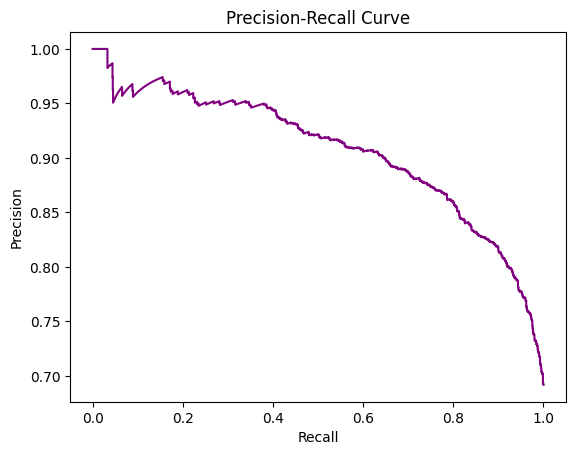

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenize

[1 1 0 ... 1 1 1]
@@ [1 1 1 ... 1 1 1] [[0.9849651 ]
 [0.98929745]
 [0.9894531 ]
 ...
 [0.99501437]
 [0.9913975 ]
 [0.99359316]]


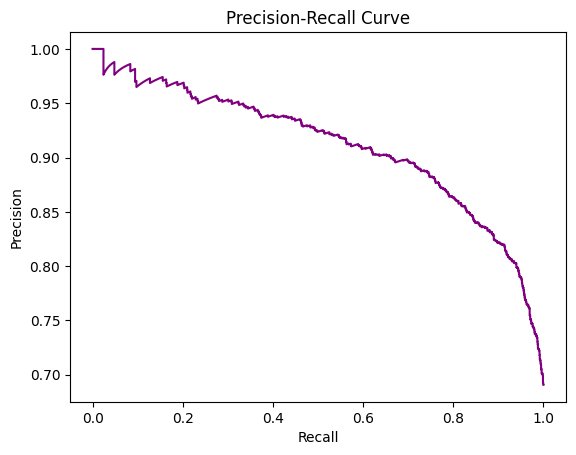

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenize

[1 1 0 ... 1 1 1]
@@ [1 1 1 ... 1 1 1] [[0.99387807]
 [0.9958633 ]
 [0.99518687]
 ...
 [0.9975501 ]
 [0.99651885]
 [0.9975924 ]]


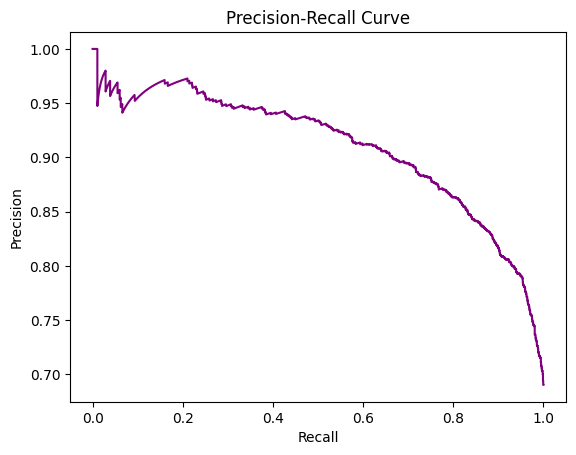



Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 18979
  Batch size = 8
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode t

[1 1 0 ... 1 1 0]
@@ [1 1 0 ... 1 1 0] [[0.99784875]
 [0.99777967]
 [0.03095887]
 ...
 [0.99808013]
 [0.99754214]
 [0.02201697]]


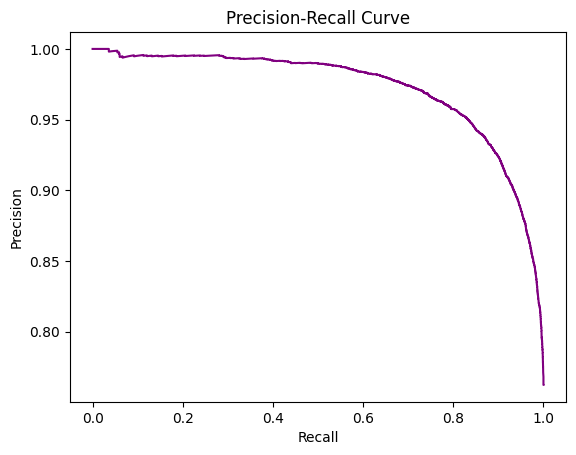

on test set: {'eval_loss': 0.4050244092941284, 'eval_val accuracy': 0.8704884345855946, 'eval_f1': 0.9165308340124966, 'eval_precision': 0.9006273358248799, 'eval_recall': 0.9330060840707964, 'eval_runtime': 50.286, 'eval_samples_per_second': 377.421, 'eval_steps_per_second': 47.19, 'epoch': 3.0}


True

In [17]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

launch = {
'distilbert': 'distilbert-base-uncased',
'deberta': 'microsoft/deberta-base',
'electra': 'google/electra-base-discriminator',
}
 
experiment = list(launch.keys())[2]+"_clickbait"
model = launch['electra']

train(model,root,nLabels,labels,experiment,trainDataset,validationDataset,testDataset)

In [18]:
print(all_computeMetrics)

[{'val accuracy': 0.771858479056527, 'f1': 0.8533333333333333, 'precision': 0.7669172932330827, 'recall': 0.9616971125515615}, {'val accuracy': 0.7759251728344856, 'f1': 0.8551143833815409, 'precision': 0.7720797720797721, 'recall': 0.9581614614024749}, {'val accuracy': 0.7848718991459943, 'f1': 0.859941752713794, 'precision': 0.7807692307692308, 'recall': 0.9569829110194461}, {'val accuracy': 0.8704884345855946, 'f1': 0.9165308340124966, 'precision': 0.9006273358248799, 'recall': 0.9330060840707964}]


In [19]:
print(test_metrics[0]['eval_val accuracy'], '\n', test_metrics[0]['eval_f1'])

0.8704884345855946 
 0.9165308340124966


In [20]:
test_metrics

[{'eval_loss': 0.4050244092941284,
  'eval_val accuracy': 0.8704884345855946,
  'eval_f1': 0.9165308340124966,
  'eval_precision': 0.9006273358248799,
  'eval_recall': 0.9330060840707964,
  'eval_runtime': 50.286,
  'eval_samples_per_second': 377.421,
  'eval_steps_per_second': 47.19,
  'epoch': 3.0}]